Non fonctionnel du a des soucis de compatibilité de version tensorflow

In [ ]:
# %pip install pandas numpy uvicorn fastapi pydantic cuda-toolkit==12.8 nvidia-cudnn-cu12==9.7.0.66 tf-nightly keras-nlp

In [ ]:
from IPython.display import display, Markdown

from pandas import DataFrame, Series
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# TensorFlow et Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import TextVectorization
import keras.backend
import keras_nlp

print(keras.backend.backend())

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"KerasNLP version: {keras_nlp.__version__}")

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

tensorflow

TensorFlow version: 2.19.1
Keras version: 3.12.0
KerasNLP version: 0.24.0
⚠️  Aucun GPU détecté - Utilisation du CPU


In [41]:
original_df: DataFrame = pd.read_parquet('https://huggingface.co/api/datasets/textdetox/multilingual_toxicity_dataset/parquet/default/fr/0.parquet')

In [42]:
df = original_df.sample(frac=1)
df.head(5).reset_index(drop=True)

,text,toxic
0,n hesitez pas a utiliser le bouton Prévisualis...,0
1,Je vais te les faire bouffer en salade avec ta...,1
2,C'est vrai que les parisiennes ont les têtes d...,1
3,C’est elle qui a conduit à la situation « post...,0
4,"En fait, ils ont repris les codes de com du FN...",0


# EDA et traitement des données

In [43]:
# Recherche d'éléments manquants
df_notna_count = len(df)
df.dropna(inplace=True)
print(f"{len(df)}/{df_notna_count} messages restants après retrait d'éventuels manque dans les données ou les labels")

5000/5000 messages restants après retrait d'éventuels manque dans les données ou les labels


In [44]:
from tensorflow import Tensor


def custom_standardisation(t: Tensor) -> Tensor:
    # https://github.com/google/re2/wiki/Syntax
    # Remplacement manuel des lettres accentuées
    t = tf.strings.regex_replace(t, "[éèêë]", "e")
    t = tf.strings.regex_replace(t, "[ÉÈÊË]", "E")
    t = tf.strings.regex_replace(t, "[àâä]", "a")
    t = tf.strings.regex_replace(t, "[ÀÂÄ]", "A")
    t = tf.strings.regex_replace(t, "[îï]", "i")
    t = tf.strings.regex_replace(t, "[ÎÏ]", "I")
    t = tf.strings.regex_replace(t, "[ôö]", "o")
    t = tf.strings.regex_replace(t, "[ÔÖ]", "O")
    t = tf.strings.regex_replace(t, "[ùûü]", "u")
    t = tf.strings.regex_replace(t, "[ÙÛÜ]", "U")
    t = tf.strings.regex_replace(t, "ç", "c")
    t = tf.strings.regex_replace(t, "Ç", "C")
    t = tf.strings.regex_replace(t, "ÿ", "y")
    t = tf.strings.regex_replace(t, "Ÿ", "Y")

    t = tf.strings.lower(t)
    t = tf.strings.regex_replace(t, r"[a-z]+://[^ ]+", "") # retrait d'url
    t = tf.strings.regex_replace(t, r"<[^>]+>", " ") # strip html tags

    t = tf.strings.regex_replace(t, r"\pP", "") # Retrait de poncutation
    t = tf.strings.regex_replace(t, r"\pS", "") # Retrait de Symboles
    t = tf.strings.regex_replace(t, r"[^\p{Latin} ]", "") # Retrait de poncutation
    
    t = tf.strings.regex_replace(t, r"(\b\w\b)", "") # retrait des mots de moins de 2 lettres
    t = tf.strings.regex_replace(t, r"\s+", " ") # retrait des espaces en trop

    t = tf.strings.strip(t)

    t = tf.strings.regex_replace(t, r"^$", "[UNK]") # en cas de chaine vide, renvois le tag [UNK] utilisé par défaut

    return t

In [45]:
# Tokenizer for stats
tokenizer = TextVectorization(
    standardize = custom_standardisation, # type: ignore
    # split = "whitespace",
    # output_sequence_length=32,
)

tokenizer.adapt(df['text'])

In [46]:
print(tokenizer.vocabulary_size()) # TODO: a optimiser avec la lemmatisation

13552


In [47]:
vocab = tokenizer.get_vocabulary()

def clean_text(text: str):
    try:
        return ' '.join([vocab[tok] for tok in np.array(tokenizer(text)).tolist() if tok > 0])
    except Exception as e:
        print(e, text)


df['text_clean'] = df['text'].apply(clean_text)
df['text_size'] = df['text_clean'].map(lambda x: len(x.split()))
print(df.head())

                                                   text  toxic  \
1501  n hesitez pas a utiliser le bouton Prévisualis...      0   
2586  Je vais te les faire bouffer en salade avec ta...      1   
2653  C'est vrai que les parisiennes ont les têtes d...      1   
1055  C’est elle qui a conduit à la situation « post...      0   
705   En fait, ils ont repris les codes de com du FN...      0   

                                             text_clean  text_size  
1501  hesitez pas utiliser le bouton previsualiser c...         16  
2586  je vais te les faire bouffer en salade avec ta...         20  
2653  cest vrai que les parisiennes ont les tetes de...         21  
1055  cest elle qui conduit la situation postdemocra...         15  
705   en fait ils ont repris les codes de com du fn ...         19  


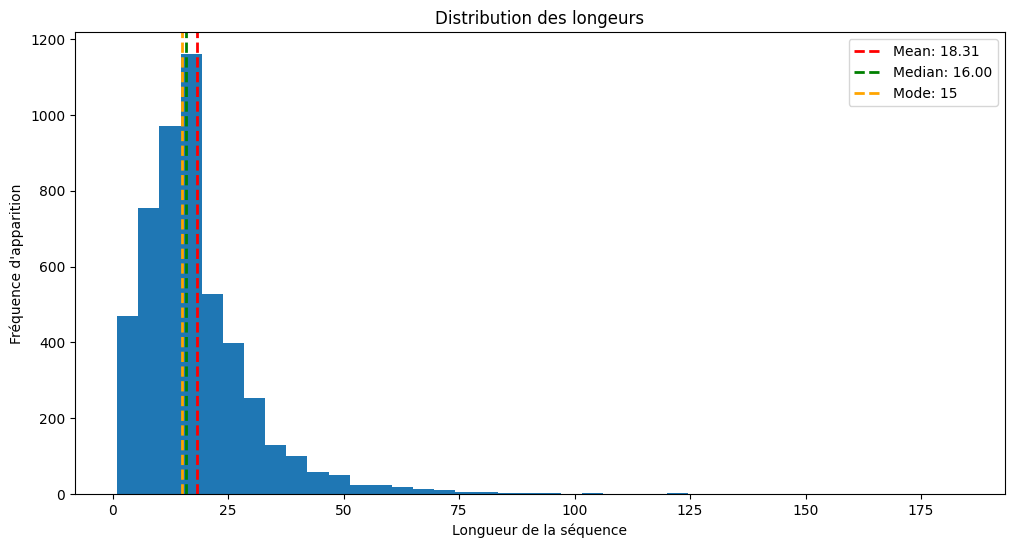

In [48]:

plt.figure(figsize=(12, 6))
plt.hist(
    x=df['text_size'],
    bins=40
)

sentences_sizes = df['text_size']
mean_val = sentences_sizes.mean()
median_val = sentences_sizes.median()
mode_val = sentences_sizes.mode()[0]

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
plt.axvline(mode_val, color='orange', linestyle='--', linewidth=2, label=f'Mode: {mode_val}')

plt.legend()
plt.xlabel("Longueur de la séquence")
plt.ylabel("Fréquence d'apparition")
plt.title('Distribution des longeurs')
plt.show()

In [49]:
df_train_X: DataFrame
df_train_y: Series
df_test_X: DataFrame
df_test_y: Series

df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(
    df, df['toxic'],
    stratify=df['toxic'],
    random_state=SEED,
    test_size=0.2
)

In [50]:

display(Markdown(
f"""
Répartition des jeux de données
- Entrainement : {len(df_train_y):n} messages avec {df_train_y.sum():n} considérés toxique ({df_train_y.sum()/len(df_train_y):.2%})
- Test : {len(df_test_y)} messages avec {df_test_y.sum():n} considérés toxique ({df_test_y.sum()/len(df_test_y):.2%})
"""))


Répartition des jeux de données
- Entrainement : 4000 messages avec 2000 considérés toxique (50.00%)
- Test : 1000 messages avec 500 considérés toxique (50.00%)


# BERT

In [51]:
# Tokenizer
tokenizer = TextVectorization(
    standardize = custom_standardisation, # type: ignore
    # split = "whitespace",
    output_sequence_length=32,
)

tokenizer.adapt(df['text'])

In [52]:
# Séquences
X_train_seq = tokenizer(df_train_X['text'])
X_test_seq = tokenizer(df_test_X['text'])

print(X_train_seq[0])

tf.Tensor(
[    8    18   207    32   117  3862     2  1326  7425  1628     2    37
  1555    10  1443  2982     4   117 12589 10160     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(32,), dtype=int64)


In [62]:
from keras.models import Sequential
import keras_nlp

bert_preprocess = keras_nlp.models.BertTextClassifierPreprocessor.from_preset('bert_base_multi')
bert_backbone = keras_nlp.models.BertBackbone.from_preset('bert_base_multi')
bert_model = keras_nlp.models.BertTextClassifier.from_preset(
    'bert_base_multi',
    preprocessor=bert_preprocess,
    backbone=bert_backbone,
    num_classes=1,
    activation="sigmoid",
    trainable=False
)

bert_model.summary()
bert_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)


Preprocessor: "bert_text_classifier_preprocessor_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                      Vocab size: 119,547 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     177,853,440 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 177,854,209 (678.46 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 177,854,209 (678.46 MB)

In [63]:
bert_model.fit(
    np.array(df_train_X['text']), df_train_y,
    validation_data=(np.array(df_test_X['text']), df_test_y),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
  1/125 ━━━━━━━━━━━━━━━━━━━━ 40:40 20s/step - binary_accuracy: 0.4688 - loss: 0.7126

KeyboardInterrupt: 